Load the data (images shape: 7000 x 28 x 28, labels shape: 7000)


In [4]:
!pip install tensorflow
!pip install keras

In [5]:
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Sequential, Model, Input
from keras import Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
import numpy as np
import pickle as pk
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras import models, layers



In [6]:
with open('input_data.pkl', 'rb') as f:
    dd = pk.load(f)

data = dd['data']
labels = dd['labels']

X_train, X_test, y_train, y_test = train_test_split(
    data, labels,
    test_size=0.2,
    random_state=42
)

print(X_train.shape, y_train.shape)


(5600, 28, 28) (5600,)


data is (7000, 28, 28), label is a 1D vector with 7000 values

CHANGE: Instead of no preprocessing, a minMaxScaler would be better on the pixels (between 0 and 1)
but could simply divide by 255 every value, same effect!

np.max(X_train[0]):1.0


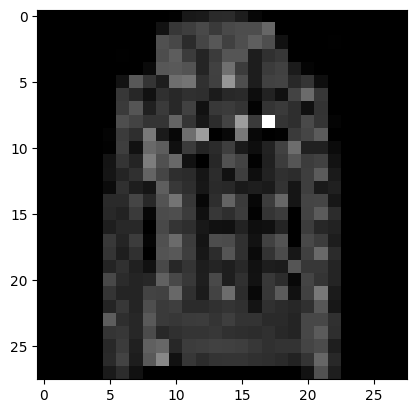

In [7]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

plt.imshow(X_train[0].squeeze(), cmap='gray')
print(f"np.max(X_train[0]):{np.max(X_train[0])}")

In [8]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print(f"X_train.shape:{X_train.shape}")
print(f"X_test.shape:{X_test.shape}")
print(f"np.max(X_train):{np.max(X_train)}, np.min(X_train):{np.min(X_train)}")

X_train.shape:(5600, 28, 28, 1)
X_test.shape:(1400, 28, 28, 1)
np.max(X_train):1.0, np.min(X_train):0.0


In [9]:
n_classes = len(np.unique(y_train))
input_shape = (X_train.shape[1], X_train.shape[2], 1)
print(f"n_classes:{n_classes}, input_shape:{input_shape}")

n_classes:10, input_shape:(28, 28, 1)


CHANGE: instead of searching from 4 to 10 (kernel size), i chose to tighten the bound to 5, 7, 9, which would save me a lot of time. not that big of a change, just faster.

In [10]:
kernel_sizes = [5, 7, 9]  # Test these kernel sizes
best_accuracy = 0
best_model = None
best_kernel = None

for k_size in kernel_sizes:
    print(f"\nTesting kernel size: {k_size}x{k_size}")

    model = Sequential([
        Conv2D(64, kernel_size=(k_size, k_size),
               input_shape=input_shape,
               padding='same',
               activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                       batch_size=64,
                       epochs=10,
                       verbose=1,
                       validation_data=(X_test, y_test))

    val_acc = max(history.history['val_accuracy'])
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_kernel = k_size
        best_model = model
        print(f"New best kernel: {k_size}x{k_size} with accuracy: {val_acc:.4f}")


print(f"\nSaved best model with kernel size {best_kernel}x{best_kernel} "
      f"(accuracy: {best_accuracy:.4f}) to 'best_conv_model.h5'")


Testing kernel size: 5x5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.6151 - loss: 1.0676 - val_accuracy: 0.8157 - val_loss: 0.5096
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8340 - loss: 0.4690 - val_accuracy: 0.8229 - val_loss: 0.4811
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8777 - loss: 0.3705 - val_accuracy: 0.8400 - val_loss: 0.4227
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8979 - loss: 0.2994 - val_accuracy: 0.8571 - val_loss: 0.3951
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8987 - loss: 0.2879 - val_accuracy: 0.8579 - val_loss: 0.3979
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9104 - loss: 0.2523 - val_accuracy: 0.8664 - val_loss: 0.3825
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9391 - loss: 0.1920 - val_accuracy: 0.8529 - val_loss: 0.4087
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9227 - loss: 0.2078 - val_accuracy: 0.8650 - val_lo

5x5 turned out to be the best! so will use 5X5 kernel (1 convolution).

SAVING THE CONVOLUTION ON conv_features.npy

In [11]:
conv_model = models.Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
])
best_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
best_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

Epoch 1/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9332 - loss: 0.1818
Epoch 2/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9532 - loss: 0.1330
Epoch 3/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9536 - loss: 0.1199
Epoch 4/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9714 - loss: 0.0893
Epoch 5/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9735 - loss: 0.0766


In [12]:
mlp_model = Sequential([
    layers.Input(shape=(conv_model.output_shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
])

In [13]:
inputs = Input(shape=(28, 28, 1))
x = conv_model(inputs)
outputs = mlp_model(x)
model = Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 4608)           │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 64)             │       598,208 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 599,040 (2.29 MB)

 Trainable params: 599,040 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

latent_dim = 2
flat_input_dim = 4608  # output shape from convolution

encoder_inputs = Input(shape=(flat_input_dim,))
x = layers.Dense(256, activation='relu')(encoder_inputs)
x = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

latent_inputs = Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(latent_inputs)
x = layers.Dense(256, activation='relu')(x)
decoder_outputs = layers.Dense(flat_input_dim, activation='sigmoid')(x)

decoder = Model(latent_inputs, decoder_outputs, name='decoder')

# VAE
outputs = decoder(z)
vae = Model(encoder_inputs, outputs, name='vae')

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=-1))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')
vae.summary()

conv_out = conv_model.predict(X_train)
conv_out = conv_out.reshape(conv_out.shape[0], -1)
print(f"conv_out.shape:{conv_out.shape}")
vae.fit(conv_out, conv_out, epochs=10, batch_size=32)


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 2), (None, 2), │     1,213,316 │
│                                 │ (None, 2))             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 4608)           │     1,217,664 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,980 (9.27 MB)

 Trainable params: 2,430,980 (9.27 MB)

 Non-trainable params: 0 (0.00 B)

175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
conv_out.shape:(5600, 4608)
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - kl_loss: 14.2736 - loss: 77.6247 - reconstruction_loss: 63.3511
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 1.2944 - loss: 12.2673 - reconstruction_loss: 10.9728
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - kl_loss: 1.1444 - loss: 10.6420 - reconstruction_loss: 9.4976
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 1.2588 - loss: 10.0647 - reconstruction_loss: 8.8059
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 1.6983 - loss: 9.2487 - reconstruction_loss: 7.5504
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 1.9148 - loss: 8.8454 - reconstruction_loss: 6.9306
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 2.0230 - loss: 8.6181 - reconstruction_loss: 6.5951
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 2.0907 - loss: 8.4608 - reconstruction_loss: 6.3701
Epoc